<a href="https://colab.research.google.com/github/aleguma/tf-cert/blob/main/04_transfer_learning_in_tensorflow_part_1_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 1: Feature Extraction

Transfer learning is one of the most powerful techniques in Deep Learning. This first notebook will cover FEATURE EXTRACTION (part 1)

### What is transfer learning?

Surely someone has spent the time crafting the right model for the job...transfer learning leverages these already created model for similar or the same task, to our own task.

The whole concept of TL is taking what one model has learned in a similar domain to our problem, and then applying it to our specific use case. Using TF we can have better results faster, far less handcrafting our architectures, as we leverage the hard work of others.

#### Example of transfer learning use cases:

* Computer vision (e.g., models built/trained using ImageNet, which is used as a benchmark for many architectures). The better the computer vision model, the better the score on identifying the 1000 classes of this data. So, if someone has spent so much time on generating a model/architecture that works very well on ImageNet to detect 1000 classes, why can't we use it for our computer vision problem? Sure we can :)

* Natural language processing (i.e., finding patterns in textual data). Same concept applies as before. You can, for instance, leverage NLP models trained on Wikipedia and adapt it to your specific use case in NLP.

So the premise of transfer learning is that *a deep learning network architecture learns patterns/weights from a similar problem space and then we tune/use the patterns to a specific (related) problem*. 

#### Why use transfer learning?

* It can leverage an existing neural network architecture **proven to work** on problems similar to our own.
* It can leverage a working network architecture which has **already learned patterns** on similar data to our own (often results in great results with less data).

For example, in a computer vision example:

1. A deep learning architecture it may learn patterns in a wide variety of images (e.g., using ImageNet).
2. It results, after a lot of effort, in a specific architecture such as *EfficientNet* or the next SOTA architecture that will replace it. So we know that the model already works really well on similar CV tasks to ours.
3. Then we leverage that pretrained architecture, we tune the patterns/weights to our own problem.
4. The model performs better than from scratch, because we are leveraging patterns already learned. 



## What we are going to cover in this notebook...

* Introduce **transfer learning** with TensorFlow
* Using a small dataset to experiment faster (10% of training samples)
* Building a **transfer learning feature extraction** model with TensorFlow hub
* Use TensorBoard to track modeling experiments and results

### Recap about transfer learning

Transfer learning is leveraging a working model's existing architecture and learned patterns for our own problem.

There are two main benefits: 
1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data. 




In [1]:
# Are we using a GPU?
!nvidia-smi   # Tesla T4

Wed Sep 21 13:19:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Downloading and becoming one with the data


In [2]:
# Before we used 750 images per class, now we are going to use the same data set but only 10% of these data
# So every class will have only 75 images!

# Get data (10% of 10 food classes from Food101 on Kaggle) - https://www.kaggle.com/dansbecker/food-101/
import zipfile

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2022-09-21 13:19:32--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.12.128, 74.125.200.128, 74.125.68.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.12.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   269MB/s    in 0.6s    

2022-09-21 13:19:32 (269 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
# How many images are in each folder?
import os

# Walk through 10 percent data directory and list the number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")


There are 2 directories and 0 images in '10_food_classes_10_percent'
There are 10 directories and 0 images in '10_food_classes_10_percent/test'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry

In [4]:
# So the test data is the same as used before, but the training data set is just 10% of the used in the previous module - Notebook 03 - (randomly selected instances)
# So instead of 750 images per training class, we are using now 75 images per class in the training data set
# This is going to highlight one of the powerful features of transfer learning. 
# So 10 times less data for the model to learn.
# Intuitively, you might think that less data leads to worse results, and that would make sense for all we have learned up to now regarding NN
# But as we will see shortly, transfer learning provides another point of view for that

In [5]:
# We should visualize the data within the folders and get familiar with it but as it is the same data as in the previous module, we skip
# this essential visualization step this time (visualize, visualize, visualize)

## Creating data loaders (preparing the data)

We will use the `ImageDataGenerator` class to load in our images in batches.

In [6]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# We will establish some constant values (capital letters) for some hyper-parameters
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 5

# Paths to folders
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

# Create the data generators instances
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:") # 10 percent of data used in module 3
train_data_10_percent = train_datagen.flow_from_directory(directory=train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")  # multi-class problem

print("Testing images:")  # same data as used in module 3, so we can compare the previous and transfer learning model with the same data
test_data = test_datagen.flow_from_directory(directory=test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical") 

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


In [7]:
# To showcase the power of transfer learning we are going to use just 10% of the training data used before
# So we have 10x less examples for our model to learn patterns on
# But the same amount of testing data

## Setting up callbacks (things to run whilst our model trains)

Callbacks are extra functionality you can add to your models to be performed during or after training. Callbacks are a a tool which can **add helpful functionality** to your models during training, evaluation or inference. Some of the most popular callbacks are:

* Tracking experiments with the *TensorBoard* callback.
  * Use case: Log the performance of multiple models and then view and compare these models in a visual way on TensorBoard (a dashboard for inspecting neural network parameters). Helpful to compare the results of different models on your data. 
  * Code: `tf.keras.callbacks.TensorBoard()`
* Model checkpoint with *ModelCheckpoint* callback.
  * Use case: Save your model as it trains so you can stop training if needed and come back to continue off where you left. Helpful if training takes a long time and you can't be done in one sitting.
  * `tf.keras.callbacks.ModelCheckpoint()`
* Stopping a model from training (before it trains too long and overfits) with the *EarlyStopping* callback.
  * Use case: Leave your model training for an arbitrary amount of time and have it stop training automatically when it ceases to improve. Helpful when you have a large dataset and do not know how long training will take. 
  * `tf.keras.callbacks.EarlyStopping()`

More [here](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback) and you can even build your own!

In [8]:
# Let's use TensorBoard to track our experiments, so we can compare them easily (among many other things TensorBoard can provide us)

In [9]:
# Create TensorBoard callback (functionized because we need to create a new one for each model)

import datetime  # we will get a timestamp of when the model was trained

def create_tensorboard_callback(dir_name, # dir_name is the file to store the callback, where the model training results are going to be stored
                                experiment_name):   # name of the model or reference to the experiment
  
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")   # creating a directory path of where to store the results
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)  # creating the callback
  print(f"Saving TensorBoard log files to: {log_dir}")  # notification message
  return tensorboard_callback  # returning the callback to be used

**Note**: You can customize the directory where your TensorBoard logs (model training metrics) get saved to whatever you like. The `log_dir` parameter we have created above is only one option.

## Creating models using [TensorFlow Hub](https://www.tensorflow.org/hub)

*TensorFlow Hub* is a repository of trained machine learning models ready for fine-tuning and deployable anywhere.

In the past, we have used TensorFlow to create our own models layer by layer from scratch. 

Now, we are going to do a similar process, except the majority of our model's layers are going to come from TensorFlow Hub.

We can access pre-trained models on: https://tfhub.dev/ and select models according to problem domain we are working on (e.g., image classification), TF version (e.g., TF2), model architecture, etc. 

When you want to use transfer learning with your problem, you want to use the model which has worked best in our particular problem domain. So, how to select a good model or architecture? You can go to a website called: https://paperswithcode.com, which collects all the latest research papers in deep learning and puts in one place (i.e., browse state-of-the-art option). They provide the best method so far for each dataset, etc. Amazing resource!! 

However, sometimes the best model might not be the best approach for you, so that is something also to keep in mind. The ranking is a good guide, but not a strict list that has to be followed. Also, some of them might not be in TF Hub yet. 

For more info we can also Google the research paper that introduced the architecture, etc. In same architecture, usually the higher the number associated to the architecture, the more complex the model.

Browsing the TensorFlow Hub page and sorting for image classification (and feature vector), we found the following feature vector model links: 

https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1 (Efficientnet) https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4 (Resnet)

We are going to use them next...

In [10]:
# Let's compare the following two models

resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

But before, summarizing...**What is TensorFlow Hub?**

* A place to find a plethora of pre-trained machine learning models (ready to be applied and fine-tuned for your own problems).
  * If the problem exists on TensorFlow Hub, it is good to leverage the models there are there are SOTA models in problem domains. 
  * TensorFlow Hub makes using a pre-trained model as simple as calling a URL. 

Let's see it working!


In [11]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [12]:
# Let's make a create_model() function to create a model from a URL
def create_model(model_url, num_classes=10):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in the output layer, should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor layer and
    Dense output layer with num_classes output neurons. 
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url, # will put the entire model into a Keras Sequential model like as we put layers into the Keras Sequential models before
                                           trainable=False, # freeze the already learned patterns, so we can leverage the learned patterns
                                           name="feature_extraction_layer",
                                           input_shape=IMAGE_SHAPE+(3,)) # syntax hack to get (224, 224, 3)
  
  # Create our own model
  model = tf.keras.Sequential([
      feature_extractor_layer,  # the input image is going to go through this whole model first
      layers.Dense(num_classes, activation="softmax", name="output_layer") # and then through our own dense layer

  ])

  return model

### Creating and testing ResNet TensorFlow Hub Feature Extraction model

In [13]:
# Create Resnet model
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)  # another way to get the number of classes in the data set

In [14]:
resnet_model.summary()  # get a summary of the created model (it is not compiled as returned by the created function)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [15]:
# Look at how many parameters!!
# But non-trainable are most of them!! The only trainable parameters are the ones in the output layer.
# So the only patterns that are going to train are the ones in the output layer, as we freezed/trainable=False the ones in the feature_extractor_layer, so it is not trainable during training!

In [16]:
# Compile our resnet model
resnet_model.compile(loss="categorical_crossentropy",  # multiclass!
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [17]:
# Let's fit our resnet model to the data (10 percent of 10 classes)
resnet_history = resnet_model.fit(train_data_10_percent, 
                                  epochs=EPOCHS,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",  # passing the callback of tensorboard we created as a function! Callbacks parameter is a ist
                                                                         experiment_name="resnet50v2")])

Saving TensorBoard log files to: tensorflow_hub/resnet50v2/20220921-131945
Epoch 1/5
24/24 [==============================] - 31s 737ms/step - loss: 1.9559 - accuracy: 0.3640 - val_loss: 1.1881 - val_accuracy: 0.6288
Epoch 2/5
24/24 [==============================] - 15s 667ms/step - loss: 0.9125 - accuracy: 0.7333 - val_loss: 0.8425 - val_accuracy: 0.7368
Epoch 3/5
24/24 [==============================] - 15s 661ms/step - loss: 0.6179 - accuracy: 0.8227 - val_loss: 0.7413 - val_accuracy: 0.7608
Epoch 4/5
24/24 [==============================] - 17s 742ms/step - loss: 0.4823 - accuracy: 0.8720 - val_loss: 0.7022 - val_accuracy: 0.7744
Epoch 5/5
24/24 [==============================] - 16s 704ms/step - loss: 0.3922 - accuracy: 0.9080 - val_loss: 0.6768 - val_accuracy: 0.7792


AWESOMEEEEEEEEEEEE RESULTS!!! The model we built from scratch with a similar architecture to the CNN explainer website provided a validation accuracy below 40%, using data augmentation and taking much longer to train (over 100s per epoch). This one is way faster, 8 times less time, and way better, doubling the performance with almost 80% accuracy! AWESOME RESULTS WITH TRANSFER LEARNING!

Incredible results. Our transfer learning feature extractor model (using the whole trained network on another data set and just using our own custom data for input and output neurons, classes, and training only that), outperformed ALL the previous models we built by hand...(substantially) and in a quicker training time AND with only 10 percent of the training examples (not using the full training data set used to train the previous models).

Let's see more...

In [18]:
# Let's create a function to plot our loss curves...
# Tidbit: you could put a function like this into a script called "helper.py" and import the library and the function when you need it...
import matplotlib.pyplot as plt

# Plot the validation and training curves
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: Tensorflow History object.

  Returns:
    Plots of training/validation loss and accuracy metrics.
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  # This part might need to be changed if another metric is used!
  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # Plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="validation_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="validation_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

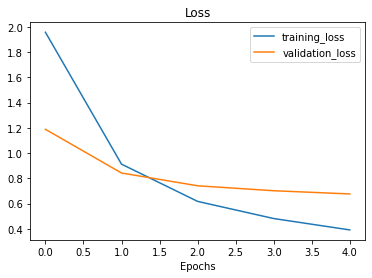

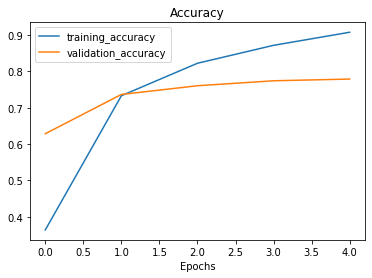

In [19]:
plot_loss_curves(resnet_history)

In [20]:
# So the curves are pretty close, this is what we tried on the previous models; get this curves as close as possible!
# Although the validation loss to be not going down as fast as the training loss! So hinting that the model might be overfitting...
# Remember overfitting: validation loss increasing while training loss decreasing! As a result of learning the training data too well.
# Accuracy curves are also quite close, so quite good!

So we are done for now with ResNet, let's build the EfficientNet model...

### Creating and testing EfficientNet B0 TensorFlow Hub Feature Extraction model

Details on [EfficientNet](https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html)

In [21]:
# Create EfficientNetB0 feature extractor model
efficientnet_model = create_model(model_url=efficientnet_url,
                                  num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss="categorical_crossentropy",   #multiclass classification
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=["accuracy"])

# Fit EfficientNet model to 10% of the training data
efficientnet_history = efficientnet_model.fit(train_data_10_percent, 
                                              epochs=EPOCHS,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", 
                                                                                     experiment_name="efficientnetb0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetb0/20220921-132137
Epoch 1/5
24/24 [==============================] - 27s 760ms/step - loss: 1.8677 - accuracy: 0.4080 - val_loss: 1.3096 - val_accuracy: 0.7296
Epoch 2/5
24/24 [==============================] - 16s 680ms/step - loss: 1.0644 - accuracy: 0.7933 - val_loss: 0.8683 - val_accuracy: 0.8212
Epoch 3/5
24/24 [==============================] - 16s 672ms/step - loss: 0.7565 - accuracy: 0.8387 - val_loss: 0.6944 - val_accuracy: 0.8436
Epoch 4/5
24/24 [==============================] - 16s 674ms/step - loss: 0.6075 - accuracy: 0.8680 - val_loss: 0.6076 - val_accuracy: 0.8536
Epoch 5/5
24/24 [==============================] - 16s 684ms/step - loss: 0.5147 - accuracy: 0.8893 - val_loss: 0.5548 - val_accuracy: 0.8608


In [22]:
# WoW! 86% accuracy on the validation data, awesome!!! Even better than the ResNet model, by 10%!! 
# And in about the same time per epoch, amazing!

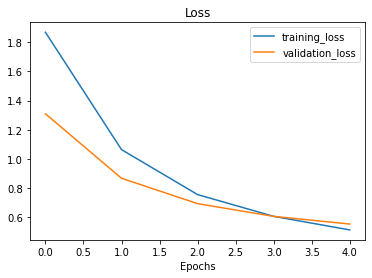

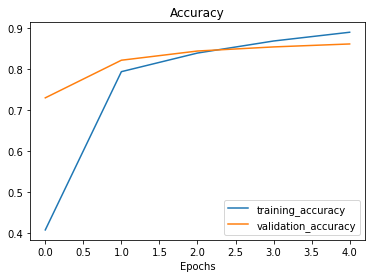

In [23]:
# Let's plot the loss curves
plot_loss_curves(efficientnet_history)

In [24]:
# BRUTAL! Both curves are extremely close in both cases!! They are very very close to the ideal scenario where both curves line up!
# And seems they could keep going, heading in the same direction!
# That could be something worth to try, to train for more epochs
# Also try other EfficientNet models, there are from B1 to B7!!

In [25]:
# Let's check the model summary...
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [26]:
# Trainable parameters are only the ones in the output layer
# The rest are frozen (non-trainable)! 
# All of the feature extraction layer parameters stay frozen/the same!
# All the layers in the pretrained architecture stay the same, all the patterns there stay the same!
# We are only updating the output layer!

In [27]:
# Let's see the summary of ResNet
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [28]:
# ResNet has almost 6 times more parameters than EfficientNet!
# EfficientNet outperforms ResNet having fewer parameters!!

In [29]:
# How many layers our EfficientNetB0 feature extractor has?
efficientnet_model.layers[0].weights  # these are the patterns that the NN has learned on previous images/data sets (original model)
# layer 0 is the feature extractor layer that is actually a whole model architecture!
# there are one of the big tensors for every layer of the original architecture, that is, a weight matrix for every layer!
# So if we want to see how many layers there are, approximately, we can do...
len(efficientnet_model.layers[0].weights)  # to have an approximate idea of how many layers there are in our EfficientNet model

309

In [30]:
# The previous models we built had 6 layers...
# Imagine how much time would be needed to build something so complex, with so many layers!

## Different types of transfer learning

* **"As is" transfer learning**: using an existing model with no changes whatsoever, not even in the last layer (e.g., using ImageNet model on 1000 ImageNet classes, none of your own). This is using the original model as it is.

* **"Feature extraction" transfer learning**: use the prelearned patterns of an existing model (e.g., EfficientNetB0 trained on ImageNet) and adjust (only) the output layer for your own problem (e.g., 1000 classes -> 10 classes of food). So original model layers do not update during training, they stay the same (frozen: *Trainable=False*); only the last layer (that we modify for our own problem) gets updated during training. And in this case we use a different dataset, but that is similar to the original data set. So, the only changes from the original model are in the input and output layers (i.e., data set and classes), so the output layer gets trained on new (input) data feature vectors that result from the feature extractor part of the network (original).

* **"Fine-tuning" transfer learning**: use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers (including new output layers). So in this case, there are more changes from the original model. The input data changes, some layers might remain frozen and some layers (or all of them) are unfrozen, thus updated during training, and the last layer is also changed. Usually, top layers get trained on our new data set, while bottom layers may not. However, as with feature extraction, these layers start off with the patterns they have learned in ImageNet. Fine-tuning usually requires more data than feature extraction. 

## Comparing our models results using TensorBoard

TensorBoard is a way to **visually explore** your machine learning models performance and internals.

It enables to host, track and share your machine learning experiments on [TensorBoard.dev](https://tensorboard.dev/). TensorBoard also integrates with websites like **[Weights & Biases](https://wandb.ai)** (check their website, we are not going to go through it here).

If we try to compare a small amount of experiments, it might be easy to check the training output. However, for many experiments, it can be messy and complicated to do so. TensorBoard can be used to track (many) experiments easily.

More info about [TensorBoard](https://www.tensorflow.org/tensorboard).

**Note**: When you upload things to TensorBoard.dev, your experiments are public. So, if you are running private experiments (things you do not want others to see), do not upload them to TensorBoard.dev.

In [ ]:
# Running TensorBoard in Colab is easy, as it is pre-installed, otherwise we should do it

# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50v2" \
  --description "Comparing two different TF Hub feature extraction model architectures using 10% of the training data" \
  --one_shot

# one_shot flag exits the uploader once the files are uploaded

Our TensorBoard experiments are uploaded publicly here: https://tensorboard.dev/experiment/zqBVploVS6i4ZZjiw40X6Q/

In [32]:
# Very cool and awesome visualization of the curves of many experiments that we can manipulate, and analyse easily!
# Many info included in the dashboard, check and experiment with the provided options!

In [33]:
# Check out what TensorBoard experiments you have stored in TensorBoard.dev
!tensorboard dev list

https://tensorboard.dev/experiment/zqBVploVS6i4ZZjiw40X6Q/
	Name                 EfficientNetB0 vs. ResNet50v2
	Description          Comparing two different TF Hub feature extraction model architectures using 10% of the training data
	Id                   zqBVploVS6i4ZZjiw40X6Q
	Created              2022-09-21 13:25:03 (9 seconds ago)
	Updated              2022-09-21 13:25:08 (just now)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5918538
https://tensorboard.dev/experiment/PvdN93PRTGeR1N5edI1LNA/
	Name                 EfficientNetB0 vs. ResNet50v2
	Description          Comparing two different TF Hub feature extraction model architectures using 10% of the training data
	Id                   PvdN93PRTGeR1N5edI1LNA
	Created              2022-09-21 11:03:05 (2 hours ago)
	Updated              2022-09-21 11:03:07 (2 hours ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes      

In [34]:
# Delete an experiment
!tensorboard dev delete --experiment_id Dpr4GjjDQ1aB1sle9m9IQQ
!tensorboard dev delete --experiment_id PvdN93PRTGeR1N5edI1LNA

Deleted experiment Dpr4GjjDQ1aB1sle9m9IQQ.
Deleted experiment PvdN93PRTGeR1N5edI1LNA.


In [35]:
# Confirm the deletion by re-checking what experiments you have left
!tensorboard dev list

https://tensorboard.dev/experiment/zqBVploVS6i4ZZjiw40X6Q/
	Name                 EfficientNetB0 vs. ResNet50v2
	Description          Comparing two different TF Hub feature extraction model architectures using 10% of the training data
	Id                   zqBVploVS6i4ZZjiw40X6Q
	Created              2022-09-21 13:25:03 (22 seconds ago)
	Updated              2022-09-21 13:25:08 (17 seconds ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5918538
Total: 1 experiment(s)


In [36]:
# Finished this part!

Practice and do more exercises [HERE](https://github.com/mrdbourke/tensorflow-deep-learning#-04-transfer-learning-in-tensorflow-part-1-feature-extraction-exercises) and extra-curriculum!!